In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, KMeans

In [2]:
# 311 Data 10/01/2021-10/01/2022 from API see 01 notebook
raw_df = pd.read_csv('./data/clean_01Oct21_01Oct22_api.csv')
df = raw_df.copy()

In [3]:
print(df.shape)
df.head()

(1042208, 16)


,requestId,createdDate,closedDate,typeId,typeName,address,lat_lon,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName
0,8610592,2021-10-01 00:01:14,2021-10-08 09:24:53,4,Bulky Items,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079512481,Phone Call,64,Pacoima
1,8610569,2021-10-01 00:02:19,2021-10-08 13:36:33,5,Electronic Waste,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516251,Phone Call,64,Pacoima
2,8610575,2021-10-01 00:03:11,2021-10-13 12:31:58,4,Bulky Items,"4539 N VISTA DEL MONTE AVE, 91403","(34.1541582469, -118.450024901)",34.154158,-118.450025,3,Sanitation Bureau,8,1-2079512561,Phone Call,72,Sherman Oaks
3,8612855,2021-10-01 00:04:14,2021-10-05 14:25:02,6,Illegal Dumping,"918 W COLLEGE ST, 90012","(34.066466398, -118.245112635)",34.066466,-118.245113,3,Sanitation Bureau,3,1-2079516331,Email,38,Historic Cultural North
4,8610587,2021-10-01 00:05:25,2021-10-08 14:16:32,7,Metal/Appliances,"11614 N HERRICK AVE, 91340","(34.2813123418, -118.425453201)",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516401,Phone Call,64,Pacoima


In [4]:
df = df[['typeId', 'latitude', 'longitude', 'agencyId', 'sourceId', 'councilId']]
#df = df[['typeId', 'councilId']]
print(df.shape)
df.head()

(1042208, 6)


,typeId,latitude,longitude,agencyId,sourceId,councilId
0,4,34.281312,-118.425453,3,8,64
1,5,34.281312,-118.425453,3,8,64
2,4,34.154158,-118.450025,3,8,72
3,6,34.066466,-118.245113,3,3,38
4,7,34.281312,-118.425453,3,8,64


# Clustering - DBSCAN

In [5]:
# smaller dataset for processing
# df_test = df.sample(frac = .01, random_state = 42)
df_test = df[:500].copy()

In [6]:
# Function created by Jeff Hale

def find_best_silhouette(X):     
    ss = StandardScaler()
    X_scaled = ss.fit_transform(X)
    max_score=-1
    for eps in np.linspace(0.2, 5, 50):
        for minsamples in range(2, round(len(X) / 2)):
            dbscan = DBSCAN(eps=eps, min_samples=minsamples)
            dbscan.fit(X_scaled)
            if len(set(dbscan.labels_)) > 1:
                score = silhouette_score(X_scaled, dbscan.labels_)
                if -1 in set(dbscan.labels_):
                    nclusters = len(set(dbscan.labels_)) - 1
                else:
                    nclusters = len(set(dbscan.labels_)) 
                if score > max_score:
                    max_score = score
                    best_eps = eps
                    best_minsamples = minsamples
                    best_clusters = nclusters
    print(f'Best silhouette score was {round(max_score, 5)}')
    print(f'Best eps was {round(best_eps, 2)}')
    print(f'Best min_samples was {best_minsamples}.')
    print(f'Model found {best_clusters} clusters.')
    return

In [7]:
find_best_silhouette(df_test)

Best silhouette score was 0.42969
Best eps was 3.04
Best min_samples was 2.
Model found 2 clusters.


In [9]:
# Scale dataframe
ss = StandardScaler()
X_sc = ss.fit_transform(df_test)

In [10]:
# Fit DBSCAN with best parameters
dbscan = DBSCAN(eps = 3.04, min_samples = 2) 
dbscan.fit(X_sc)

DBSCAN(eps=3.04, min_samples=2)

## Evaluation

In [11]:
# Labels
print(pd.Series(dbscan.labels_).unique())

[0 1]


In [12]:
silhouette_score(X_sc, dbscan.labels_) # -1 to 1

0.42968703142579234

In [13]:
# Create cluster column
df_test['cluster'] = dbscan.labels_

In [14]:
df_test.cluster.value_counts(normalize = True, ascending = False)

0    0.954
1    0.046
Name: cluster, dtype: float64

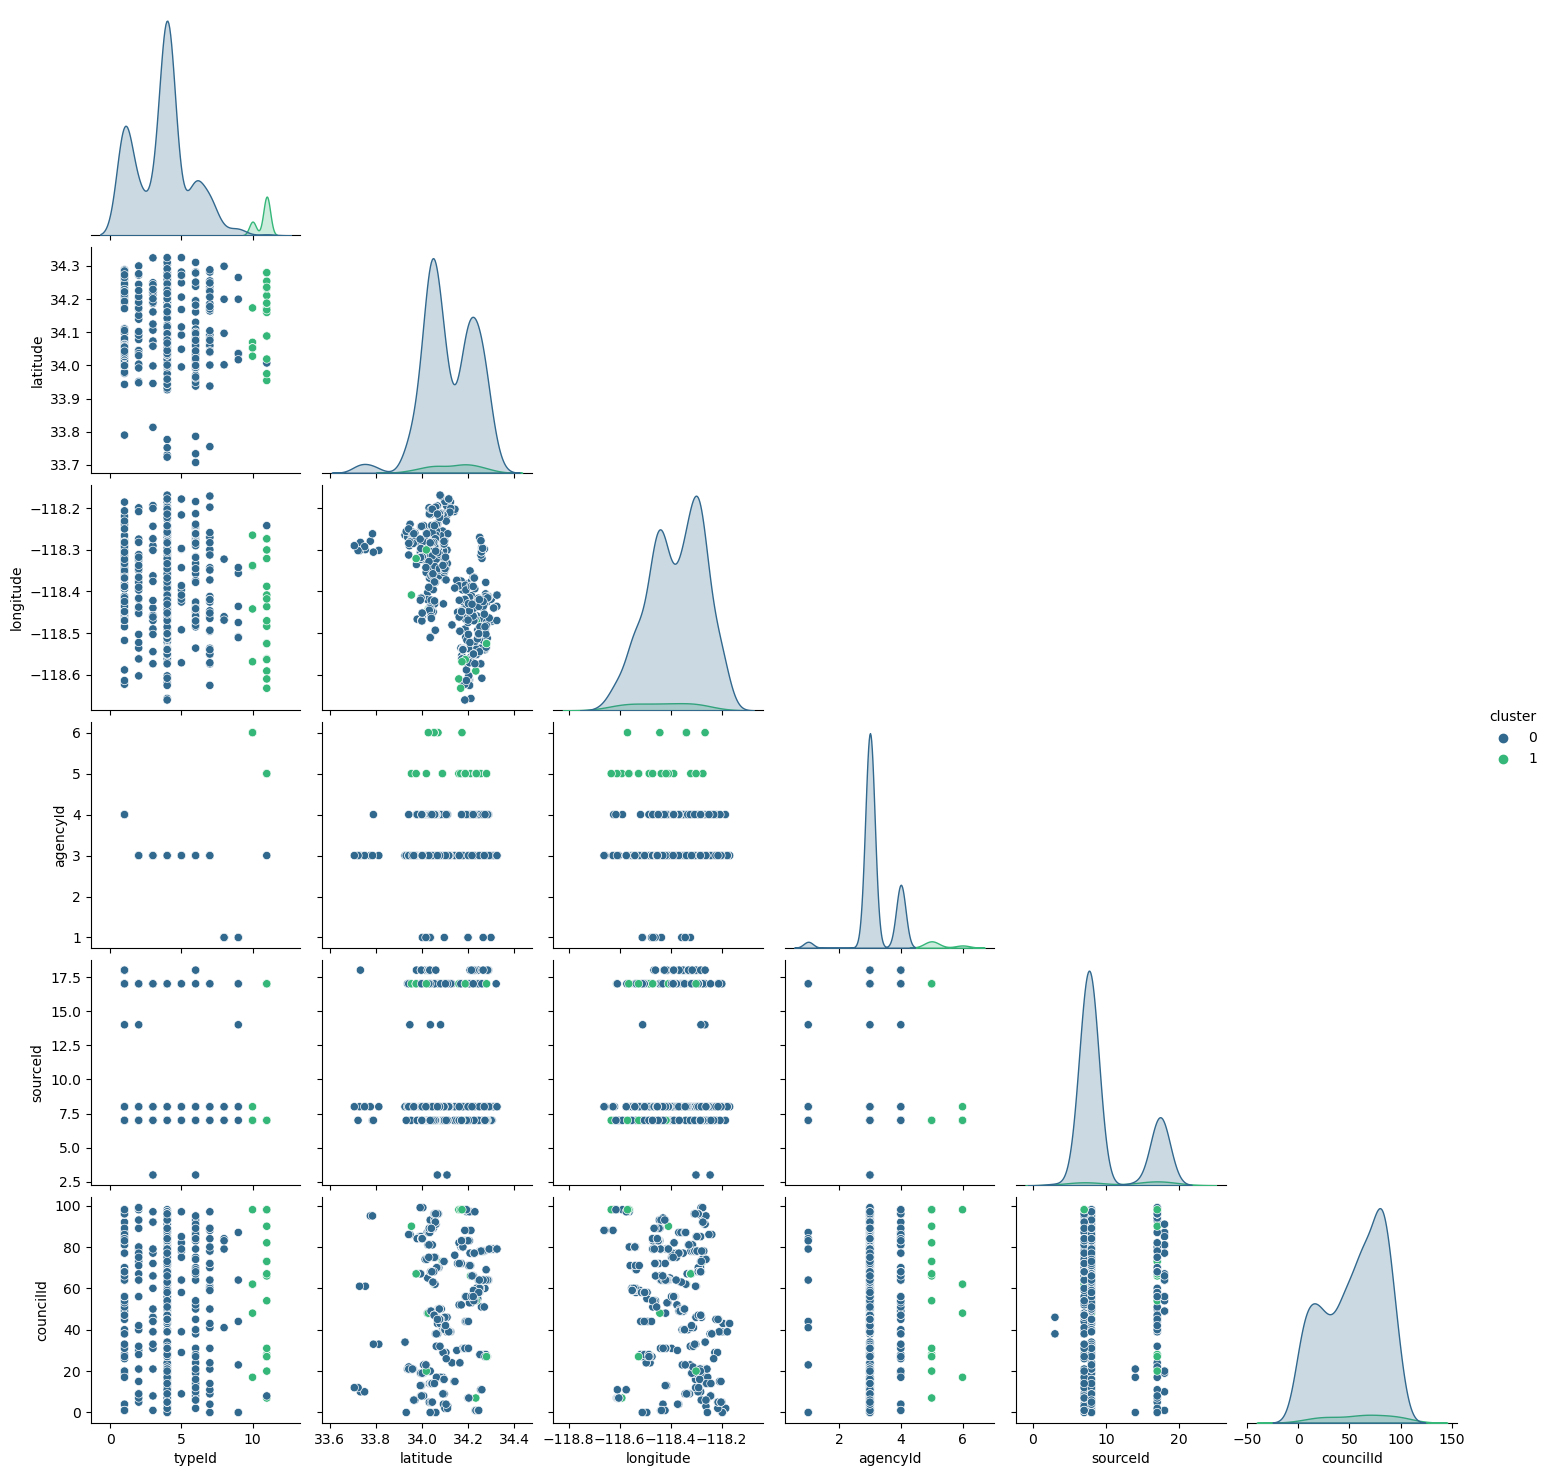

In [15]:
# Pairplot
sns.pairplot(df_test, hue = 'cluster', palette = 'viridis', corner = True);